Final Project, Zuriahn Yun, Task 4

In [ ]:
# Imports
import numpy as np
import pandas as pd
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
import sklearn
import wandb
from sklearn.metrics import accuracy_score, log_loss
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
"""
Config File:
N_TRAIN  1699860
N_DEV    234376
D        13
C        61
"""
# Standardize Method
def standardize(X):
 return (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Grab Data, target,feature order
class Dataset():
    def __init__(self,targetFilename,featureFilename):
        traintarget = np.loadtxt(targetFilename, delimiter=" ")
        trainfeature = np.loadtxt(featureFilename,delimiter=" ")
        self.X = trainfeature
        self.y = traintarget
    # Retrieve X and y based on index
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    # Size of Dataset
    def __len__(self):
        return len(self.X)
    
# Grab test Data and Standardize
class testDataset():
    def __init__(self,featureFilename):
        trainfeature = np.loadtxt(featureFilename,delimiter=" ")
        self.X = standardize(trainfeature)
    # Retrieve X and y based on index
    def __getitem__(self, index):
        return self.X[index]
    # Size of Dataset
    def __len__(self):
        return len(self.X)

# Get a random Subset of data
def get_subset(X,y, subset_size):
    indices = torch.randperm(X.shape[0])[:subset_size]
    featureSubset = X[indices]
    targetSubset = y[indices]
    return featureSubset,targetSubset

# Logans Split dataset Function
def split_dataset(dataset, p=0.8):
    train_size = int(p * len(dataset))
    val_size = len(dataset) - train_size

    return torch.utils.data.random_split(dataset, [train_size, val_size])

In [ ]:
# Load Data
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
dev = Dataset("task4_phoneme/dev.CT","task4_phoneme/dev.X")

In [ ]:
# On the train set 
# Convert the tensor to a NumPy array
X_train,y_train = get_subset(train.X,train.y,5000)
X_dev,y_dev = get_subset(dev.X,dev.y,1000)

numpy_X = X_train.detach().numpy()

numpy_y = y_train.detach().numpy()

# Create a Pandas DataFrame from the NumPy array
X_df = pd.DataFrame(numpy_X)
y_df = pd.DataFrame(numpy_y)


y_df.describe()

,0
count,5000.000000
mean,20.008400
std,15.989818
min,0.000000
25%,7.000000
50%,17.000000
75%,30.000000
max,60.000000


c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


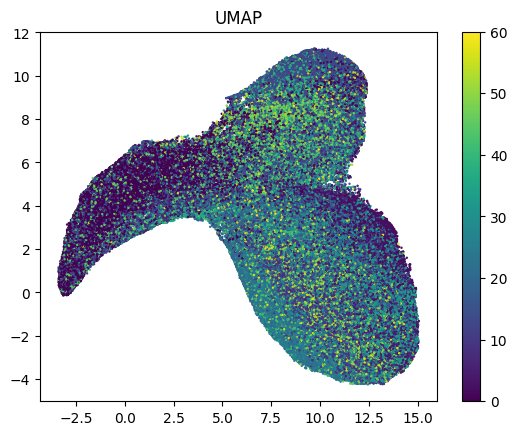

In [ ]:
# U Map
import umap.umap_ as umap

train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")

X,y = get_subset(train.X,train.y,200000)

# Fit UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
X_2d = umap_model.fit_transform(X)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, s=0.5)
plt.colorbar()
plt.title("UMAP")
plt.show()

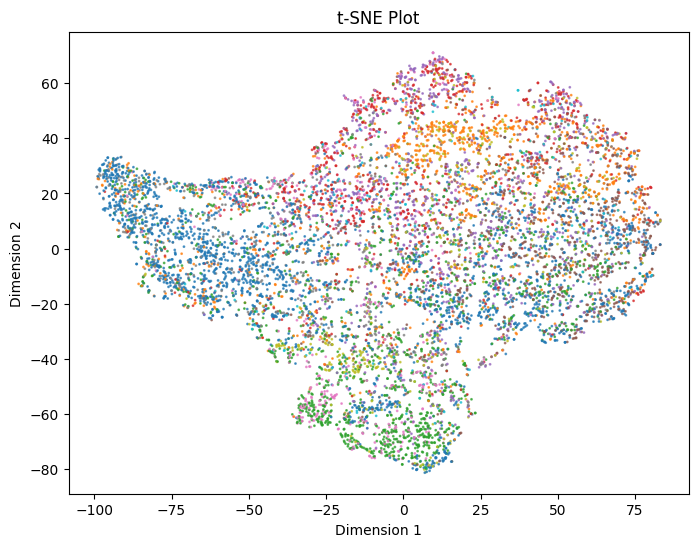

In [ ]:
# T-SNE Plot
tsne = TSNE(n_components=2, random_state=0)

X,y = get_subset(train.X,train.y,10000)

X_np = X.numpy()
y_np = y.numpy()

X_embedded = tsne.fit_transform(X_np)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_np, cmap='tab10', alpha=0.7,s=1)
plt.title('t-SNE Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

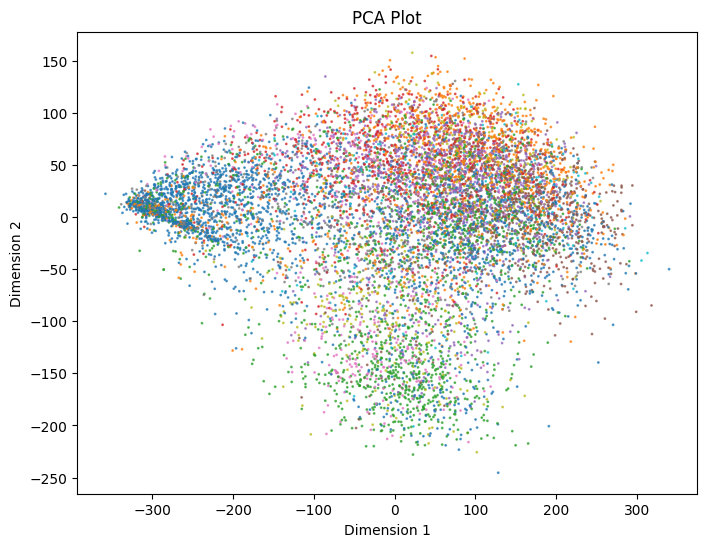

In [15]:
# PCA Plot
pca = PCA(n_components=2, random_state=0)
X,y = get_subset(train.X,train.y,10000)

X_np = X.numpy()
y_np = y.numpy()

X_embedded = pca.fit_transform(X_np)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_np, cmap='tab10', alpha=0.7,s=1)
plt.title('PCA Plot')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

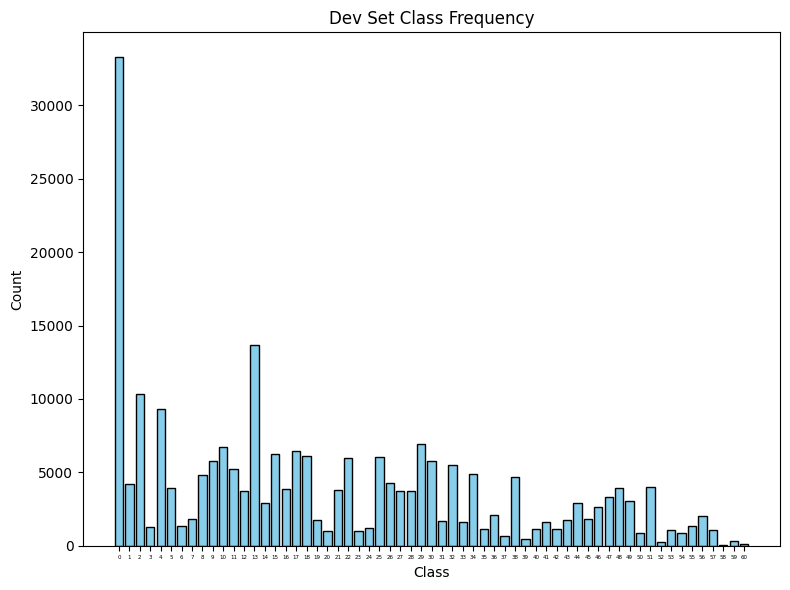

In [ ]:
# Frequency Chart
dev = Dataset("task4_phoneme/dev.CT","task4_phoneme/dev.X")
y_dev = dev.y
classes, counts = np.unique(y_dev, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.title('Dev Set Class Frequency')
plt.xlabel('Class')
plt.ylabel('Count')
# Lower font size
plt.xticks(classes, fontsize=4)
# Show all class labels
plt.xticks(classes) 
plt.tight_layout()
plt.show()

In [6]:
import joblib
# SVM is so insanely Slow its not even worth it 
# This Block serves to make predictions with models that have already been trained
model = joblib.load('nn_model.pkl')

dev = Dataset("task4_phoneme/dev.CT","task4_phoneme/dev.X")

X = standardize(dev.X)
y_dev = dev.y
print("Data Loaded")
y_dev_pred = model.predict(X)
print("Predictions Made")
y_dev_proba = model.predict_proba(X)
print("Predicted Probabilities")

dev_accuracy = accuracy_score(y, y_dev_pred)
dev_logloss = log_loss(y, y_dev_proba)

print(dev_accuracy)
print(dev_logloss)

import pandas as pd

results = pd.DataFrame({
    'Index': range(len(y_dev)),
    'True Label': y_dev,
    'Predicted Label': y_dev_pred
})

results.to_csv("dev_predictions.csv", index=False)

# XGB .4191
# NN .44292

Data Loaded
Predictions Made
Predicted Probabilities
0.44296344335597504
1.9170833646680379


In [4]:
# Test Set Prediction
import joblib
import pandas as pd

model = joblib.load('nn_model.pkl')

test = testDataset('test.X')

X = test.X

print("Data Loaded")
y_labels = model.predict(X)
print("Predictions Made")

results = pd.DataFrame(y_labels)

results.to_csv("task4.predictions", index=False)


Data Loaded
Predictions Made


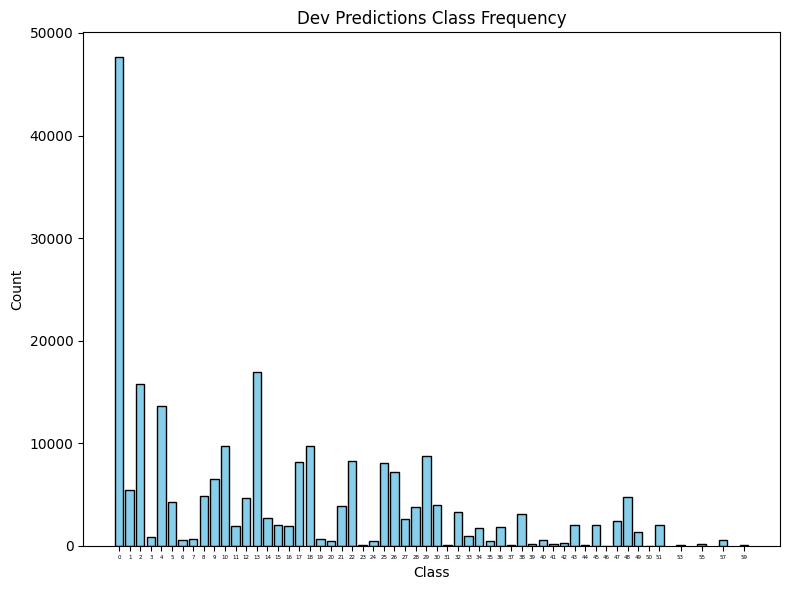

In [12]:
# Prediction Frequency Chart 
dfpreds = pd.read_csv('dev_predictions.csv')
preds = dfpreds['Predicted Label']

classes, counts = np.unique(preds, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(classes, counts, color='skyblue', edgecolor='black')
plt.title('Dev Predictions Class Frequency')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(classes, fontsize=4)
plt.xticks(classes)  # Make sure all class labels are shown
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
import wandb
from wandb.sklearn import plot_classifier
import numpy as np

# Load and split dataset
train = Dataset("task4_phoneme/train.CT", "task4_phoneme/train.X")
X = train.X
y = train.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.001, test_size=0.0001, stratify=y, random_state=42
)

X_train = standardize(X_train)
X_test = standardize(X_test)

# Define parameter grid
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100), (100, 100, 100)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.01, 0.1],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'adaive'],
    'early_stopping': [True, False]
}

# Log Loss
log_loss_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True, labels=np.unique(y))

# Initialize wandb sweep run manually
run = wandb.init(project="MachineLearning", name="MLP Grid Search", config=param_grid)

# Setup grid search
grid_search = GridSearchCV(
    MLPClassifier(max_iter=300),  
    param_grid,
    scoring=log_loss_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
    return_train_score=True
)

grid_search.fit(X_train, y_train)

# Log Results
for i, params in enumerate(grid_search.cv_results_['params']):
    wandb.log({
        "params": params,
        "mean_train_log_loss": -grid_search.cv_results_['mean_train_score'][i],
        "mean_test_log_loss": -grid_search.cv_results_['mean_test_score'][i],
    })

best_model = grid_search.best_estimator_

y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

test_log_loss = log_loss(y_test, y_test_proba, labels=best_model.classes_)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Log final performance
wandb.log({
    "best_params": grid_search.best_params_,
    "test_log_loss": test_log_loss,
    "test_accuracy": test_accuracy
})

print("Best Params:", grid_search.best_params_)
print("Test Log Loss:", test_log_loss)
print("Test Accuracy:", test_accuracy)

run.finish()

wandb: Currently logged in as: zuriahnyun1 (zuriahnyun1-western-washigton-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan 

Best Params: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
Test Log Loss: 2.5249500901457127
Test Accuracy: 0.3764705882352941


test_accuracy,▁
test_log_loss,▁
mean_test_log_loss,nan
mean_train_log_loss,nan
test_accuracy,0.37647
test_log_loss,2.52495


In [ ]:
# Best Neural Network Model 
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
import joblib

# Load Data
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
dev = Dataset("task4_phoneme/dev.CT","task4_phoneme/dev.X")

X_train = train.X
y_train = train.y

X_dev = dev.X
y_dev = dev.y

X_train = standardize(X_train)
X_dev = standardize(X_dev)

print("Data Standardized and Loaded")

# Best Params: {'activation': 'relu', 'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.001}
# Initialize wandb sweep run manually

run = wandb.init(
    project="MachineLearning",
    name="Neural Network best grid search params",
    config={
        "learning_rate": "constant",
        "learnin rate init": 0.001,
        "Early Stopping":"true",
        "activation":"relu",
        "Hidden Layer Size":(100),
        "alpha": 0.0001,      
    }
)

nn = MLPClassifier(hidden_layer_sizes = (100), activation = 'relu',alpha = 0.0001, learning_rate_init=0.001,early_stopping=True,learning_rate='constant')

nn.fit(X_train,y_train)

print("Done Training")

# Make Class Predictions 
y_train_pred = nn.predict(X_train)

#log = log_loss(y_train, y_train_proba)
accuracy = accuracy_score(y_train,y_train_pred)


# Make Test Predictions
y_test_pred = nn.predict(X_test)
#y_test_proba = nn.predict_proba(X_test)

#testlog = log_loss(y_test, y_test_proba,)
testaccuracy = accuracy_score(y_test,y_test_pred)

#print("Train Log Loss: " ,log)
print("Train Accuracy: ", accuracy)
#print("Test Log Loss: " ,testlog)
print("Test Accuracy: ", testaccuracy)

wandb.log({
    "train_accuracy": accuracy,
    #"train_log_loss": log,
    "test_accuracy": testaccuracy,
    #"testlog": testlog
    })

# Save Best nn 
joblib.dump(nn, 'nn_model.pkl')

wandb.finish()

Data Standardized and Loaded


Done Training
Train Accuracy:  0.4397762168649183
Test Accuracy:  0.4470588235294118


test_accuracy,▁
train_accuracy,▁
test_accuracy,0.44706
train_accuracy,0.43978


In [12]:
# Ensemble Model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neural_network import MLPClassifier
import wandb
from sklearn.model_selection import train_test_split
import nbformat
from xgboost import XGBClassifier
import joblib
import numpy as np
from sklearn.metrics import accuracy_score, log_loss
import wandb

# Start wandb run
run = wandb.init(
    project="MachineLearning",
    name="XGBOOST+NN+LG+RF",
    config={
        "architecture": "Manual Ensemble (NN + XGBoost + Logistic Regression + Random Forest)",
        "dataset": "Task 4 (dev set only)",
    }
)

# Load models
clf_nn = joblib.load("nn_model.pkl")
clf_xgb = joblib.load("xgb_model.pkl")
clf_lg = joblib.load("lr_model.pkl")
clf_rf = joblib.load("rf_model.pkl")

# Load and standardize dev set
dev = Dataset("task4_phoneme/dev.CT", "task4_phoneme/dev.X")
X_dev = standardize(dev.X)
y_dev = dev.y

# Get class probabilities
proba_nn = clf_nn.predict_proba(X_dev)
proba_xgb = clf_xgb.predict_proba(X_dev)
proba_lg = clf_lg.predict_proba(X_dev)
proba_rf = clf_rf.predict_proba(X_dev)

# Manual soft voting: average the probabilities
proba_avg = (proba_nn + proba_xgb + proba_lg + proba_rf) / 4

# Get predicted classes
y_pred = np.argmax(proba_avg, axis=1)

# Evaluate
accuracy = accuracy_score(y_dev, y_pred)
logloss = log_loss(y_dev, proba_avg)

print("Dev Set Accuracy:", accuracy)
print("Dev Set Log Loss:", logloss)

wandb.log({
    "dev_accuracy": accuracy,
    "dev_log_loss": logloss
})

wandb.finish()

Dev Set Accuracy: 0.44211011366351505
Dev Set Log Loss: 1.9687834067113208


dev_accuracy,▁
dev_log_loss,▁
dev_accuracy,0.44211
dev_log_loss,1.96878


In [5]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import wandb

maxdepth = 6
estimators = 10
learningrate = 0.01
sample_bytree = 0.6
trainSize = 0.05
testSize = 0.01

# Dataset loading (assumed already done)
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
X = train.X
y = train.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=trainSize, test_size=testSize, stratify=y, random_state=42
)

X_train = standardize(X_train)
X_test = standardize(X_test)

# Initialize W&B
run = wandb.init(
    project="MachineLearning",
    config={
        "model": "XGBoost",
        "dataset": "Task 4",
        "max_depth": str(maxdepth),
        "learning_rate": str(learningrate),
        "n_estimators": str(estimators),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "Subsample": 0.5,
    }
)

# Create the model
xgb = XGBClassifier(
    max_depth= maxdepth,
    learning_rate= learningrate,
    n_estimators= estimators,
    use_label_encoder=False,
    eval_metric="mlogloss",
    num_class = 61,
    subsample = 0.5,
    colsample_bytree=str(sample_bytree),
)

# Fit the model
xgb.fit(X_train, y_train)

# Train metrics
y_train_pred = xgb.predict(X_train)
y_train_proba = xgb.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_logloss = log_loss(y_train, y_train_proba)

# Test metrics
y_test_pred = xgb.predict(X_test)
y_test_proba = xgb.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_logloss = log_loss(y_test, y_test_proba)

print("Train Log Loss: " ,train_logloss)
print("Train Accuracy: ", train_accuracy)
print("Test Log Loss: " ,test_logloss)
print("Test Accuracy: ", test_accuracy)

# Log results
run.notes = " XGBoost on 5% training data 1% test"

run.log({
    "train_accuracy": train_accuracy,
    "train_log_loss": train_logloss,
    "test_accuracy": test_accuracy,
    "test_log_loss": test_logloss
})

run.finish()

# This was ran one final time to remove errors from the output 

c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:52:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Train Log Loss:  3.755757654207683
Train Accuracy:  0.39966820797006813
Test Log Loss:  3.7745947773886313
Test Accuracy:  0.3753750220601212


test_accuracy,▁
test_log_loss,▁
train_accuracy,▁
train_log_loss,▁
test_accuracy,0.37538
test_log_loss,3.77459
train_accuracy,0.39967
train_log_loss,3.75576


In [ ]:
# Setting up variables to easily manually change hyperparameters
maxdepth = 6
estimators = 1000
learningrate = 0.01
sample_bytree = 0.6
trainSize = 0.05
testSize = 0.01

# Dataset loading (assumed already done)
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
X = train.X
y = train.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=trainSize, test_size=testSize, stratify=y, random_state=42
)

X_train = standardize(X_train)
X_test = standardize(X_test)

# Initialize W&B
run = wandb.init(
    project="MachineLearning",
    config={
        "model": "XGBoost",
        "dataset": "Task 4",
        "max_depth": str(maxdepth),
        "learning_rate": str(learningrate),
        "n_estimators": str(estimators),
        "use_label_encoder": False,
        "eval_metric": "mlogloss",
        "Subsample": 0.5,
    }
)

# Create the model
xgb = XGBClassifier(
    max_depth= maxdepth,
    learning_rate= learningrate,
    n_estimators= estimators,
    use_label_encoder=False,
    eval_metric="mlogloss",
    num_class = 61,
    subsample = 0.5,
    colsample_bytree=str(sample_bytree),
)

# Fit the model
xgb.fit(X_train, y_train)

# Train metrics
y_train_pred = xgb.predict(X_train)
y_train_proba = xgb.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_logloss = log_loss(y_train, y_train_proba)

# Test metrics
y_test_pred = xgb.predict(X_test)
y_test_proba = xgb.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_logloss = log_loss(y_test, y_test_proba)

print("Train Log Loss: " ,train_logloss)
print("Train Accuracy: ", train_accuracy)
print("Test Log Loss: " ,test_logloss)
print("Test Accuracy: ", test_accuracy)

# Log results
run.notes = " XGBoost on 5% training data 1% test"

run.log({
    "train_accuracy": train_accuracy,
    "train_log_loss": train_logloss,
    "test_accuracy": test_accuracy,
    "test_log_loss": test_logloss
})

run.finish()

In [ ]:
# Manually Change variables for testing
trainSize = 0.05
testSize = 0.01

# Dataset loading
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
X = train.X
y = train.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=trainSize, test_size=testSize, stratify=y, random_state=42
)

# Initialize W&B
run = wandb.init(
    project="MachineLearning",
    config={
        "model": "Multi Class SVM",
        "dataset": "Task 4",
        "kernel": "linear",
        "c":1.0,
        "Decision Function Shape":"ovr",
    }
)

svm = SVC(
    kernel='linear',        
    C=1.0,                  
    decision_function_shape='ovr',  
    probability= False      
)


# Fit the models
svm.fit(X_train, y_train)

# Train metrics
y_train_pred = svm.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)


# Test metrics
y_test_pred = svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)


print("Train Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Log results
run.notes = "SVM on 5 train and 1 percent test"

run.log({
    "train_accuracy": train_accuracy,   
    "test_accuracy": test_accuracy,
})

run.finish()

wandb: Currently logged in as: zuriahnyun1 (zuriahnyun1-western-washigton-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Train Accuracy:  0.40563340510394974
Test Accuracy:  0.401023589622919


test_accuracy,▁
train_accuracy,▁
test_accuracy,0.40102
train_accuracy,0.40563


In [ ]:
trainSize = 0.8
testSize = 0.2

# Dataset loading (assumed already done)
train = Dataset("task4_phoneme/train.CT","task4_phoneme/train.X")
X = train.X
y = train.y

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=trainSize, test_size=testSize, stratify=y, random_state=42
)

X_train = standardize(X_train)
X_test = standardize(X_test)

# Initialize W&B
run = wandb.init(
    project="MachineLearning",
    config={
        "model": "Random Forrest",
        "dataset": "Task 4",
        "n_estimators": 100,
        "Max Features": "sqrt",
        "max depth": 10,
        "max leaf nodes":100,
    }
)

RandomForest = RandomForestClassifier(
    n_estimators=100, 
    max_features="sqrt", 
    max_depth=10, 
    max_leaf_nodes=100,
)

RandomForest.fit(X_train,y_train)
joblib.dump(RandomForest, 'rf_model.pkl')
# Train metrics
y_train_pred = RandomForest.predict(X_train)
#y_train_proba = RandomForest.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, y_train_pred)
#train_logloss = log_loss(y_train, y_train_proba)

# Test metrics
y_test_pred = RandomForest.predict(X_test)
#y_test_proba = RandomForest.predict_proba(X_test)

test_accuracy = accuracy_score(y_test, y_test_pred)
#test_logloss = log_loss(y_test, y_test_proba)

#print("Train Log Loss: " ,train_logloss)
print("Train Accuracy: ", train_accuracy)

#print("Test Log Loss: " ,test_logloss)
print("Test Accuracy: ", test_accuracy)

# Log results
run.notes = "Random Forest on 10% training data 5% test"

run.log({
    "train_accuracy": train_accuracy,
    "test_accuracy": test_accuracy,
})

run.finish()

Train Accuracy:  0.36603234972291837
Test Accuracy:  0.36506535832362663


test_accuracy,▁
train_accuracy,▁
test_accuracy,0.36507
train_accuracy,0.36603


In [9]:
# Manually Change variables
C = 1.0          
max_iter = 10 
solver = "lbfgs"
multi_class = "multinomial"

# Load Data
dev = Dataset("task4_phoneme/dev.CT","task4_phoneme/dev.X")
train = Dataset("task4_phoneme/train.CT", "task4_phoneme/train.X")


X_train = train.X
y_train = train.y

y_test = dev.y

X_train = standardize(X_train)
X_test = standardize(dev.X)
print("loaded")
# Initialize W&B
run = wandb.init(
    project="MachineLearning",
    config={
        "model": "LogisticRegression",
        "dataset": "Task 4",
        "C": C,
        "max_iter": max_iter,
        "solver": solver,
        "multi_class": multi_class,
    }
)

# Create the model
lr = LogisticRegression(
    C=C,
    max_iter=max_iter,
    solver=solver,
    multi_class=multi_class
)
print("Fitting")
# Fit the model
lr.fit(X_train, y_train)
print("Done fitting")
# Train metrics
y_train_pred = lr.predict(X_train)
y_train_proba = lr.predict_proba(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_logloss = log_loss(y_train, y_train_proba)

# Test metrics
y_test_pred = lr.predict(X_test)
y_test_proba = lr.predict_proba(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_logloss = log_loss(y_test, y_test_proba)

print(test_accuracy)
print(test_logloss)

loaded


Fitting


c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\zuria\School\WWU School Work 24-25\Spring\Data 471\Task4 Final Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Done fitting
0.3957444448237021
2.209359449554812
